# Overfitting, Regularization and Information Criteria 

In [154]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import theano
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### The Problem with parameters

###### Code 6.1

In [2]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


###### Figure 6.2

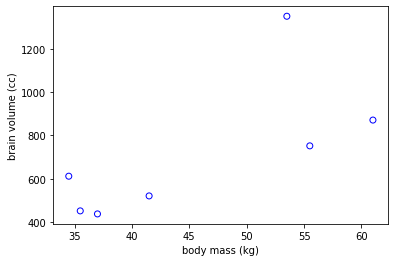

In [3]:
plt.scatter(d.mass, d.brain, facecolors='none', edgecolors='b')
plt.xlabel('body mass (kg)')
plt.ylabel('brain volume (cc)');

###### Code 6.2

In [4]:
m6_1 = smf.ols('brain ~ mass', data=d).fit()

###### Code 6.3

In [5]:
1 - m6_1.resid.var() / d.brain.var()

0.490158047949084

###### Code 6.4

In [6]:
m6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

###### Code 6.5

In [7]:
m6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

###### Figure 6.3

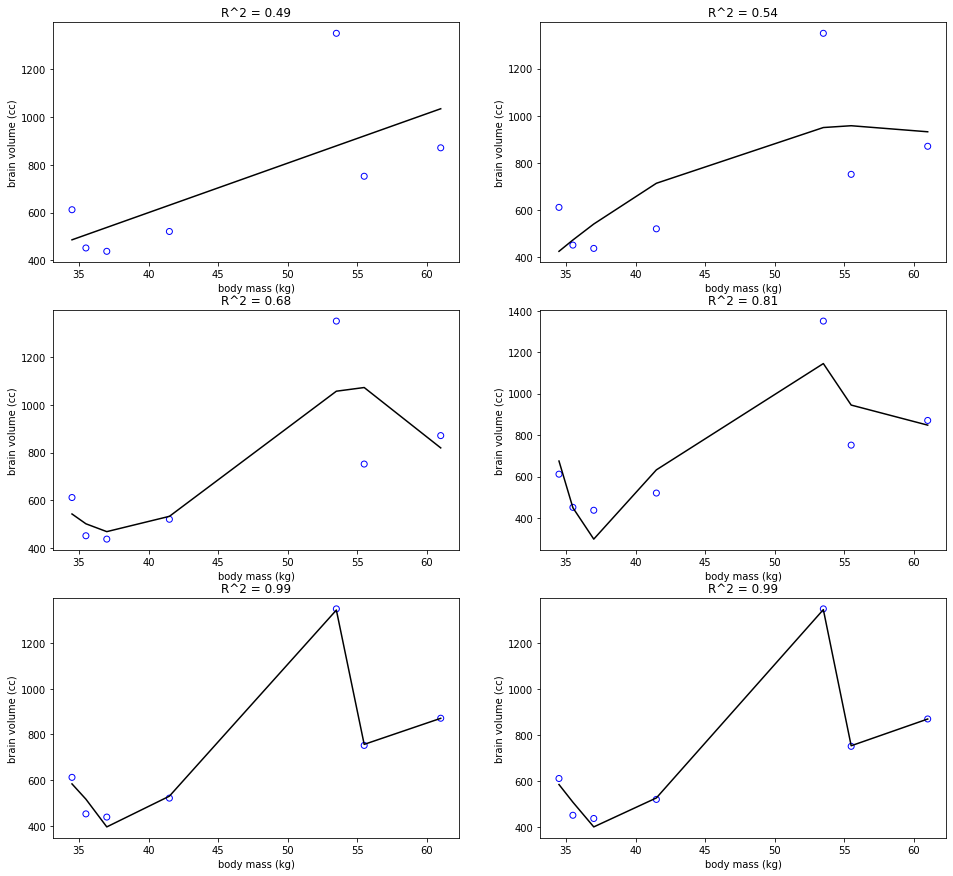

In [8]:
_, axes = plt.subplots(3, 2, figsize=(16,15))
models = [m6_1, m6_2, m6_3, m6_4, m6_5, m6_6]
for ax, model in zip(axes.ravel(), models):
    ax.scatter(d.mass, d.brain, facecolors='none', edgecolors='b')
    sns.lineplot(d.mass, model.fittedvalues, color='k', ax=ax)
    ax.set_title('R^2 = {}'.format(model.rsquared.round(2)))
    ax.set_xlabel('body mass (kg)')
    ax.set_ylabel('brain volume (cc)')
    
plt.show()

###### Code 6.6

In [9]:
m6_7 = smf.ols('brain ~ 1', data=d).fit()

###### Figure 6.4

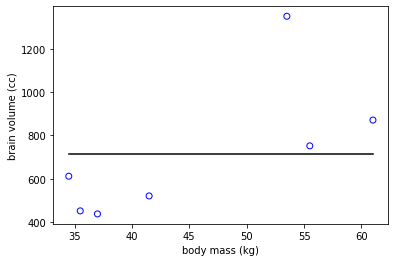

In [10]:
plt.scatter(d.mass, d.brain, facecolors='none', edgecolors='b')
sns.lineplot(d.mass, m6_7.fittedvalues, color='k')
plt.xlabel('body mass (kg)')
plt.ylabel('brain volume (cc)');

###### Code 6.7

In [11]:
d_new = d.drop(d.index[-1])

###### Code 6.8 and Figure 6.5

In [12]:
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


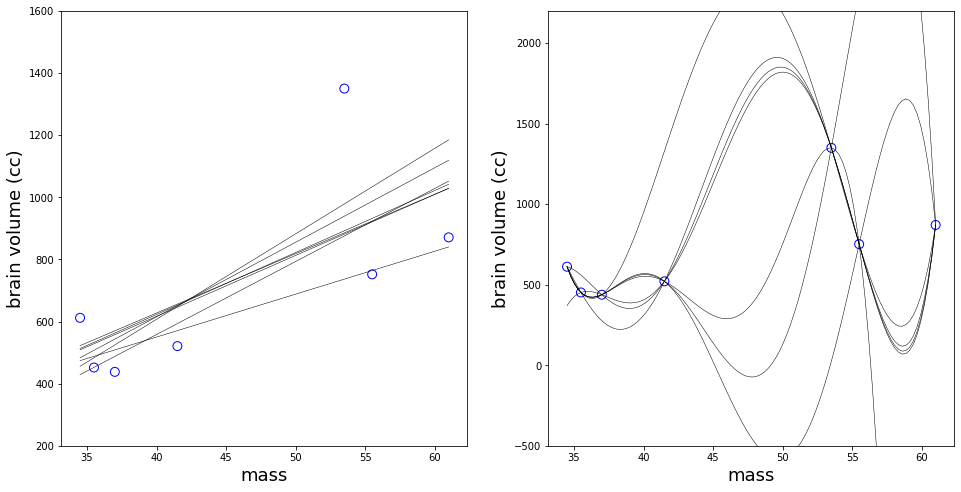

In [13]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

for ax in [ax1,ax2]:
    ax.scatter(d.mass, d.brain, facecolors='none', edgecolors='b', s=80)
    ax.set_xlabel('body mass (kg)', fontsize=18)
    ax.set_ylabel('brain volume (cc)', fontsize=18)

for i in range(d.shape[0]):
    d_new = d.drop(d.index[i])
    m1 = smf.ols('brain ~ mass', data=d_new).fit()
    m5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    mass_seq = pd.DataFrame(np.linspace(d.mass.min(), d.mass.max(), 100), columns=['mass'])
    sns.lineplot(mass_seq.mass, m1.predict(mass_seq.mass), ax=ax1, ci=None, color='k', lw=0.5)
    sns.lineplot(mass_seq.mass, m5.predict(mass_seq.mass), ax=ax2, ci=None, color='k', lw=0.5)
    
ax1.set_ylim([200, 1600])
ax2.set_ylim([-500, 2200]);

### Information theory and model performance

###### Code 6.9

In [14]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

###### Figure 6.6

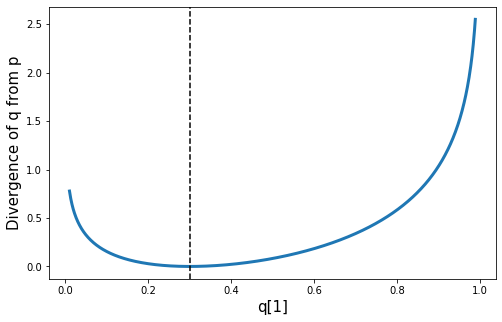

In [15]:
x = np.arange(0.01, 0.99, 0.001)
p = np.array([0.3, 0.7])
q = np.array([x, 1-x]).T
divergence = np.apply_along_axis(lambda x: -np.sum(p * (np.log(x) - np.log(p))), 1, q)

plt.figure(figsize=(8,5))
plt.plot(q[:,0], divergence, lw=3)
plt.xlabel('q[1]', fontsize=15)
plt.ylabel('Divergence of q from p', fontsize=15)
plt.axvline(x=0.3, color='k', ls='--');

###### Code 6.10

In [16]:
# fit the model
m_6_1 = smf.ols('brain ~ mass', d).fit()

In [17]:
# deviance by cheating
-2 * m_6_1.llf

94.92498968588757

###### Code 6.11

In [18]:
# Standardize the mass before fitting
d['mass_s'] = (d.mass - d.mass.mean()) / d.mass.std()

with pm.Model() as m_6_8:
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    trace_6_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1916.81draws/s]


In [19]:
theta = pm.stats.summary(trace_6_8, varnames=['~mu'])['mean']

In [20]:
dev = -2 * stats.norm.logpdf(d['brain'], loc=theta[0] + d['mass_s'] * theta[1], scale=theta[2]).sum()
dev

100.03813770875355

###### Code 6.12

In [21]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    ## Make var-covar matrix
    n_dim = max(1+len(rho), k)
    # Empty covariances
    Rho = np.diag(np.ones(n_dim))
    # Fill upper triangle
    Rho[0, 1:(len(rho)+1)] = rho
    # Replicate upper triangle to lower part
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    # get test and train data
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.concatenate([np.ones((N,1)), x_train[:, 1:k]], axis=1)
    mm_test = np.concatenate([np.ones((N,1)), x_test[:, 1:k]], axis=1)

    with pm.Model() as m_sim:
        # vec_V build distribution based on number of parameters, k, in model 
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(k), 
                            shape=(1, k), testval=np.random.randn(1, k)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        trace_m_sim = pm.sample()

    vec = pm.summary(trace_m_sim, var_names=['vec_V'])['mean'].values.reshape(k, -1)

    dev_train = - 2 * sum(stats.norm.logpdf(x_train, loc = np.matmul(mm_train, vec), scale = 1))    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    

    return np.mean(dev_train), np.mean(dev_test)

###### Code 6.13

In [36]:
Ns = [20, 100]
tries = 20
num_param = np.arange(5) + 1
r = np.zeros(shape=(len(num_param), 4, 2))

for i, n in enumerate(Ns):
    for j in num_param:
        print(j+1)
        train = []
        test = []
        for _ in range(tries):
            tr, te = sim_train_test(N=n, k=j);
            train.append(tr), test.append(te)
        r[j - 1, :, i] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2026.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1731.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2266.05draws/s]
The acceptance probability does not match the target. It is 0.8816399682539068, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|████

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1827.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1900.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2014.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1757.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1660.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1668.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1824.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1708.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1733.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1264.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1128.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1022.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1438.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1488.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1346.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1356.64draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1454.34draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1842.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1803.06draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
The acceptance probability does not match the target. It is 0.8867238106117974, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does no

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1354.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1570.83draws/s]
The acceptance probability does not match the target. It is 0.885973235768108, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1551.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|█████

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1462.32draws/s]
The acceptance probability does not match the target. It is 0.8814056458015702, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1569.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1322.36draws/s]
The acceptance probability does not match the target. It is 0.8838119936033073, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS samp

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 939.28draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1275.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1094.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 20

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 982.23draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:06<00:00, 332.26draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 515.39draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 682.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chain

###### Code 6.14

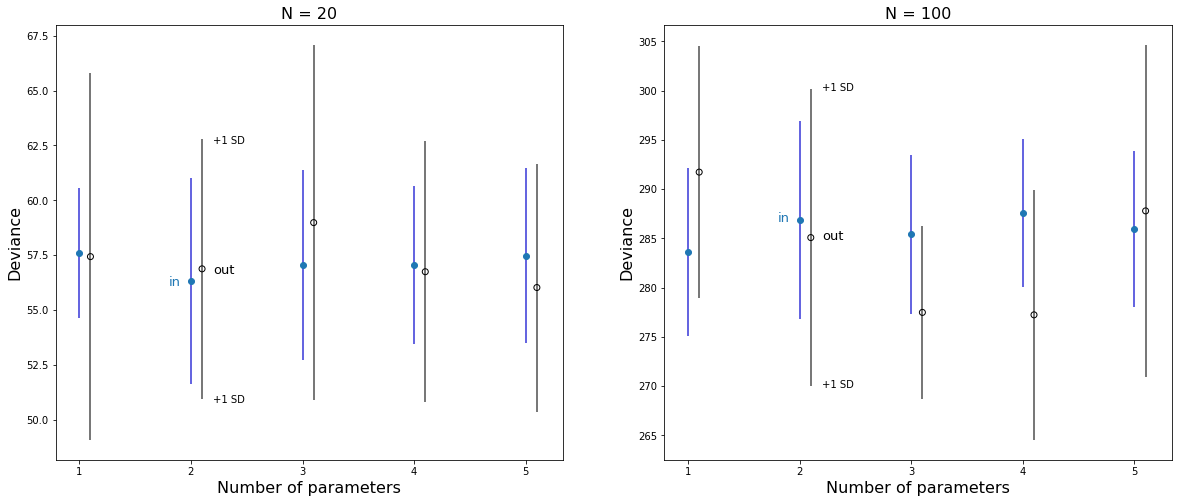

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
dist = 0.20

for i, (n, ax) in enumerate(zip(Ns, [ax1, ax2])):
    rn = r[:,:,i]
    ax.scatter(num_param, rn[:, 0], color='C0')
    ax.scatter(num_param + 0.1, rn[:, 2], facecolors='none', edgecolors='k')
    ax.set_xticks(num_param)

    for i, j in enumerate(num_param):
        ax.vlines(j, rn[i,0] - rn[i, 1], rn[i,0] + rn[i,1], color='mediumblue', 
                   zorder=-1, alpha=0.80)
        ax.vlines(j + 0.1, rn[i,2] - rn[i, 3], rn[i,2] + rn[i,3], color='k', 
                   zorder=-2, alpha=0.70)    

    
    ax.text(num_param[1] - dist, rn[1, 0] - dist, 'in', color='C0', fontsize=13)
    ax.text(num_param[1] + dist, rn[1, 2] - dist, 'out', color='k', fontsize=13)
    ax.text(num_param[1] + dist, rn[1, 2] + rn[1,3] - dist, '+1 SD', color='k', fontsize=10)
    ax.text(num_param[1] + dist, rn[1, 2] - rn[1,3] - dist, '+1 SD', color='k', fontsize=10)
    ax.set_xlabel('Number of parameters', fontsize=16)
    ax.set_ylabel('Deviance', fontsize=16)
    ax.set_title('N = {}'.format(n), fontsize=16)
plt.show()

### Regularization

###### Figure 6.8

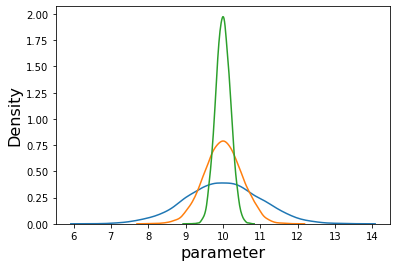

In [68]:
n = 10000
mu = 10

for sd in [1, 0.5, 0.2]: 
    rp1 = stats.norm.rvs(loc=mu, scale=sd, size=n)
    sns.distplot(rp1, hist=False)
    
plt.ylabel("Density", fontsize=16)
plt.xlabel("parameter", fontsize=16);

###### Figure 6.9

In [72]:
Ns = [20, 100]
tries = 20
num_param = np.arange(5) + 1
sd = [200, 1, 0.5, 0.2]
r = np.zeros(shape=(len(num_param), 4, len(sd), len(Ns)))

for i, n in enumerate(Ns):
    for j in num_param:
        print(j+1)
        for s_idx, s in enumerate(sd):
            train = []
            test = []
            for _ in range(tries):
                tr, te = sim_train_test(N=n, k=j, b_sigma=s);
                train.append(tr), test.append(te)
            r[j - 1, :, s_idx , i] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1537.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2175.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1952.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2053.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2052.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2162.84draws/s]
The acceptance probability does not match the target. It is 0.8909962055194082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838399245779973, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2062.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2048.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2168.23draws/s]
The acceptance probability does not match the target. It is 0.8963240121271326, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1491.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2069.51draws/s]
The acceptance probability does not match the target. It is 0.8790386309814561, but s

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1813.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1319.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1863.58draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1754.81draws/s]
The acceptance probability does not match the target. It is 0.8900016364211879, but should be close to 0

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1511.55draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1699.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1693.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1840.22draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampli

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1030.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1512.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1238.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1625.70draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampli

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1448.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1203.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1658.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 20

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1280.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1265.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1632.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1730.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampli

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1578.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1683.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1639.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1257.49draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|████████

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1445.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1481.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 753.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1163.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock)

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1448.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 854.12draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 803.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1248.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess samplin

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 806.71draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 564.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1348.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1448.89draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1486.97draws/s]
Auto-assigning

6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 753.05draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 656.36draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 880.42draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1432.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1353.29draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1242.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1443.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1295.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampli

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1438.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1297.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1267.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1094.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 974.29draws/s] 
Auto-assignin

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1643.68draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1768.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1788.05draws/s]
The acceptance probability does not match the target. It is 0.9030345149603898, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|████

NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1672.87draws/s]
The acceptance probability does not match the target. It is 0.8797415542804902, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1597.08draws/s]
The acceptance probability does not match the target. It is 0.8818502411873782, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1793.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1222.91draws/s]
The acceptance probability does not match the target. It is 0.8886742713668916, but should be close to 0.8. Try to increase the number of tuning steps.
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1225.46draws/s]
The acceptance probability does not match the target. It is 0.884321867144773, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains

NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1859.18draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1650.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1596.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1737.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1762.42draws/s]

3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1385.77draws/s]
The acceptance probability does not match the target. It is 0.8827655166918537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882288993589201, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1091.74draws/s]
The acceptance probability does not match the target. It is 0.8872976414425635, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess samplin

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1556.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1442.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1388.63draws/s]
The acceptance probability does not match the target. It is 0.9008951540002248, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1456.15draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiproc

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1427.29draws/s]
The acceptance probability does not match the target. It is 0.8906769287890072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947435260247812, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1389.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1529.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2

4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1463.50draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1281.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1289.47draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1386.88draws/s]
The acceptance probability does not match the target. It is 0.8827873628152653, but should be close to 0

INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1265.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1302.40draws/s]
The acceptance probability does not match the target. It is 0.8851997937763959, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1213.30draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in

NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1315.09draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1357.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1049.10draws/s]
The acceptance probability does not match the target. It is 0.8798941089452157, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0

5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1214.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1257.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1196.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1099.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1193.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1257.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1192.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1266.90draws/s]
The acceptance probability does not match the target. It is 0.8791110794378914, but should be close to 0.8. Try to increase the number 

NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1190.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1250.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 721.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1051.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1179.05draws/s]


6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1209.68draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1041.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1123.60draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 20

NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1175.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1259.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1196.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1185.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1207.70draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1267.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1124.77draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1081.24draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1157.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1157.75draws/s]
Auto-assignin

In [73]:
r

array([[[[ 58.02295084, 286.55609493],
         [ 57.35688079, 287.86999993],
         [ 56.66242792, 283.13814058],
         [ 56.64839369, 286.12680859]],

        [[  4.62133519,   8.51555948],
         [  3.79012076,   9.45355223],
         [  4.73303231,   8.15599314],
         [  4.03349502,   8.70397944]],

        [[ 55.17526841, 288.64771727],
         [ 61.6080687 , 286.83643431],
         [ 60.16609148, 282.62443169],
         [ 58.08495628, 282.02689996]],

        [[  4.93122831,  16.55865907],
         [  5.92026443,  17.26471293],
         [  6.40464165,  10.65112148],
         [  6.91002302,  11.14482347]]],


       [[[ 57.11525869, 282.78381351],
         [ 56.49783979, 286.21124967],
         [ 58.99696998, 281.87836198],
         [ 55.96930206, 284.50109673]],

        [[  3.61325708,   6.97686859],
         [  3.58430195,   8.17293291],
         [  3.40026527,   7.78219425],
         [  2.78384069,   9.97927357]],

        [[ 60.80317718, 281.85849027],
         [ 

In [77]:
r[:,0,0,0]

array([58.02295084, 57.11525869, 55.9346158 , 58.84624936, 57.36350651])

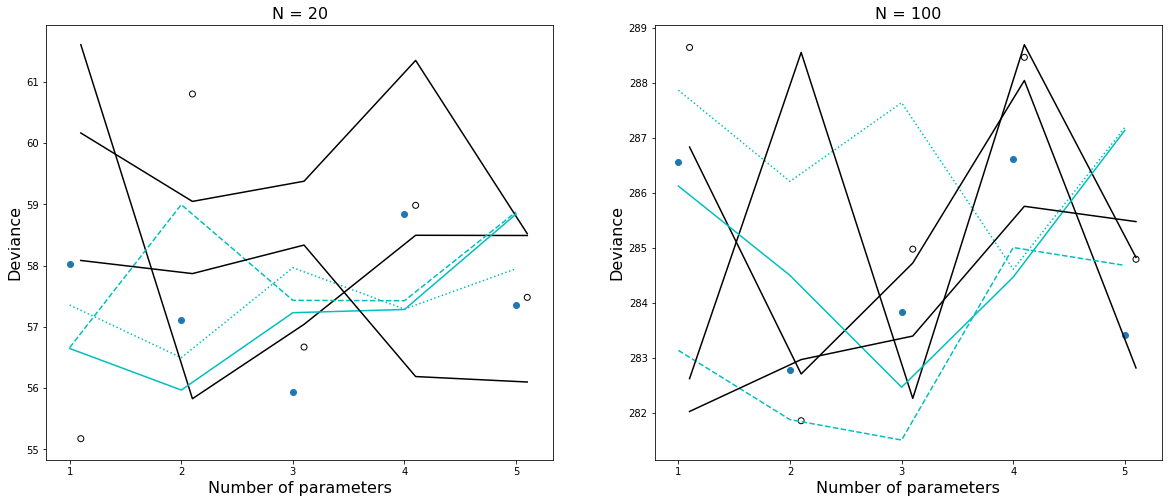

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
dist = 0.20

linestyles={1:':', 0.5:'--', 0.2:'-'}

for i, (n, ax) in enumerate(zip(Ns, [ax1, ax2])):
    
    for j, scale in enumerate(sd):
        rn = r[:,:,j,i]
        if j == 0:
            ax.scatter(num_param, rn[:, 0], color='C0')
            ax.scatter(num_param + 0.1, rn[:, 2], facecolors='none', edgecolors='k')
        else:
            ax.plot(num_param, rn[:, 0], color='C', label=f"N(0, {scale})", linestyle=linestyles[scale])
            ax.plot(num_param + 0.1, rn[:, 2], color='k')

    ax.set_xticks(num_param)
    ax.set_xlabel('Number of parameters', fontsize=16)
    ax.set_ylabel('Deviance', fontsize=16)
    ax.set_title('N = {}'.format(n), fontsize=16)
plt.show()

### Information Criteria

###### Figure 6.10

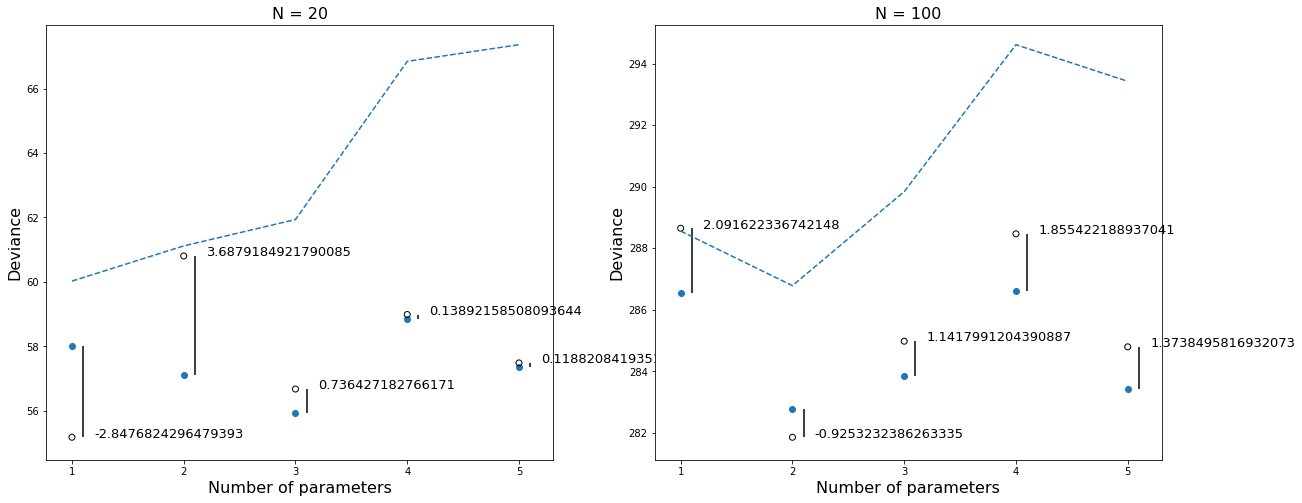

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
dist = 0.20

for i, (n, ax) in enumerate(zip(Ns, [ax1, ax2])):
    rn = r[:,:,0,i]
    aic = rn[:, 0] + 2 * num_param
    d_diff = rn[:, 2] - rn[:, 0]
    
    ax.plot(num_param, aic, linestyle='--')
    ax.scatter(num_param, rn[:, 0], color='C0')
    ax.scatter(num_param, rn[:, 2], facecolors='none', edgecolors='k')
    ax.set_xticks(num_param)

    for idx, j in enumerate(num_param):
        ax.vlines(j + 0.1, rn[idx,0], rn[idx,2], color='k', zorder=-1)
        ax.text(j + 0.2, rn[idx, 0] + d_diff[idx], d_diff[idx], fontsize=13)
    ax.set_xlabel('Number of parameters', fontsize=16)
    ax.set_ylabel('Deviance', fontsize=16)
    ax.set_title('N = {}'.format(n), fontsize=16)
plt.show()

###### Code 6.15

In [87]:
df = pd.read_csv('../../data/cars.csv', sep=',')

with pm.Model() as m_6_15:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * df["speed"])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    trace_6_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:12<00:00, 328.25draws/s]
The acceptance probability does not match the target. It is 0.892283934513606, but should be close to 0.8. Try to increase the number of tuning steps.


###### Code 6.16

In [90]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

for i in range(n_samples):
    mu = trace_6_15['a'][i] + trace_6_15['b'][i] * data["speed"]
    ll[:,i] = stats.norm.logpdf(data['dist'], loc=mu, scale=trace_6_15['sigma'][i])

###### Code 6.17

In [94]:
lppd = np.zeros((n_cases))
for a in range(n_cases):
    lppd[a] = np.log(np.sum(np.exp(ll[a,:]))) - np.log(n_samples)

###### Code 6.18

In [97]:
pWAIC = np.zeros((n_cases))
for a in range(n_cases):
    pWAIC = np.var(ll[a,:])

###### Code 6.19

In [99]:
-2 * ( np.sum(lppd) - np.sum(pWAIC))

413.47905824412965

###### Code 6.20

In [101]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt( n_cases * np.var(waic_vec))

10.345425150809735

###### Figure 6.11

### Using Information Criteria

###### Code 6.21

In [102]:
d = pd.read_csv('../../data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

###### Code 6.22

In [112]:
a_start = d['kcal.per.g'].mean()
sigma_start = d['kcal.per.g'].std()

In [169]:
mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    bm = pm.Normal('bm', mu=0, sd=10, testval=0)
    mu = alpha + bm * mass_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(1000, tune=1000)

with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    bn = pm.Normal('bn', mu=0, sd=10, testval=0)
    mu = alpha + bn * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    bn = pm.Normal('bn', mu=0, sd=10, testval=0)
    bm = pm.Normal('bm', mu=0, sd=10, testval=0)
    mu = alpha + bm * mass_shared + bn * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1375.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1018.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:17<00:00, 231.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hamzaiqb/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Multiproc

###### Code 6.23

In [170]:
waic_6_14 = az.waic(trace_m6_14, pointwise=True)
print(waic_6_14)

Computed from 2000 by 17 log-likelihood matrix

        Estimate       SE
IC_waic   -16.87     4.92
p_waic      3.06        -

There has been a warning during the calculation. Please check the results.


###### Code 6.24

In [171]:
compare_df = az.compare({
    'm_6_11': trace_m6_11,
    'm_6_12': trace_m6_12,
    'm_6_13': trace_m6_13,
    'm_6_14': trace_m6_14,
}, method='pseudo-BMA')
compare_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_14,0,-16.8665,3.05808,0,0.96089,4.92408,0,True,deviance
m_6_11,1,-8.73471,1.3295,8.13182,0.0164767,3.6471,4.64682,False,deviance
m_6_12,2,-8.65858,2.14186,8.20796,0.0158613,4.1739,3.21372,True,deviance
m_6_13,3,-6.95654,1.98581,9.90999,0.00677245,3.11884,4.85787,False,deviance


###### Code 6.25

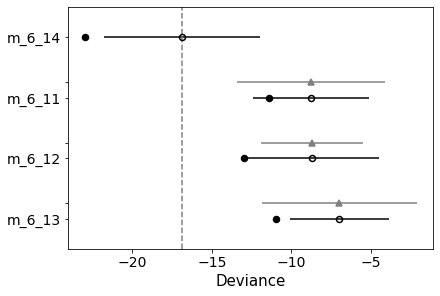

In [173]:
az.plot_compare(compare_df);

###### Code 6.26

In [174]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff < 0) / 100000

0.17793

###### Code 6.27  & Figure 6.12

In [175]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.657,0.708,0.295,-1.026
bm,NaN,-0.033,NaN,-0.094
bn,NaN,NaN,0.536,2.700
sigma,0.188,0.183,0.194,0.140


###### Code 6.28

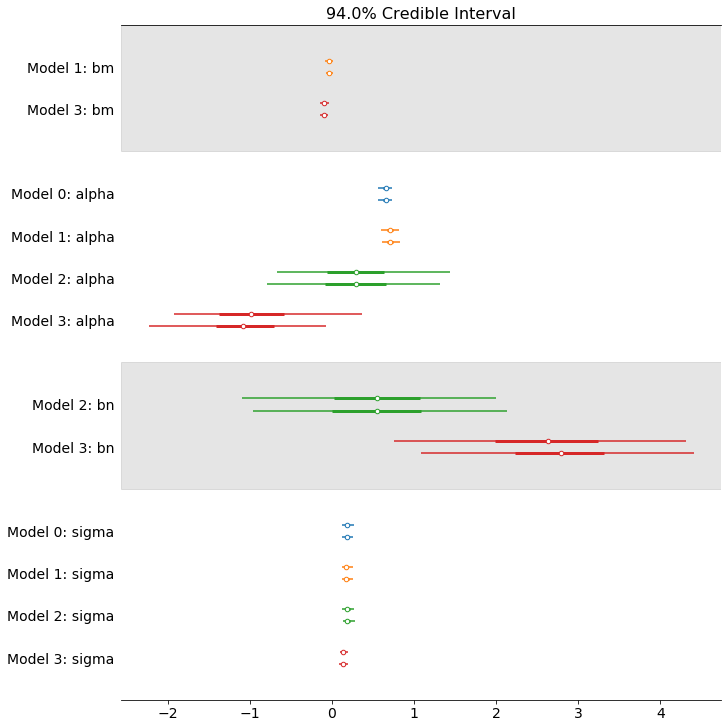

In [176]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
az.plot_forest(traces, figsize=(10, 10));

###### Code 6.29

In [177]:
kcal_per_g = np.repeat(0, 30)  # empty outcome
neocortex = np.linspace(0.5, 0.8, 30)  # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

In [179]:
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_posterior_predictive(trace_m6_14, samples=10000, model=m6_14)

100%|██████████| 10000/10000 [00:43<00:00, 231.94it/s]


###### Code 6.30

In [181]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]
milk_ensemble = pm.sample_posterior_predictive_w(traces, 10000, 
                                                 models,
                                                 weights=compare_df.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:33<00:00, 296.19it/s]


###### Figure 6.13

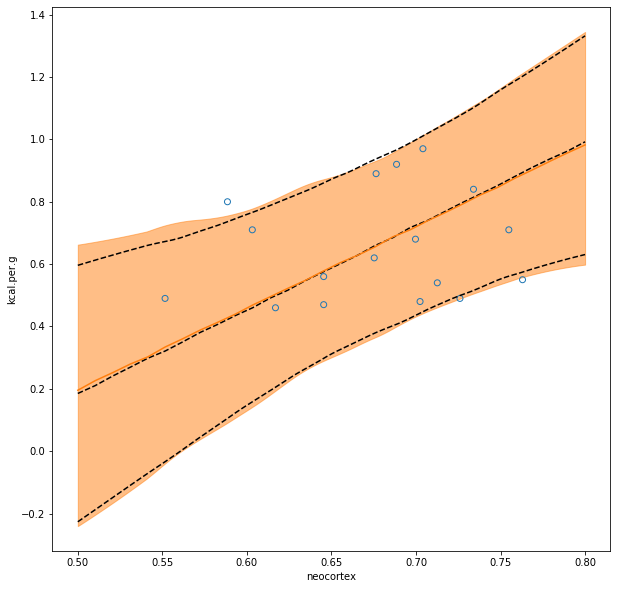

In [192]:
plt.figure(figsize=(10, 10))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='k')
az.plot_hpd(neocortex, post_pred['kcal'],
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})
plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C1')
az.plot_hpd(neocortex, milk_ensemble['kcal'])

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

# plt.ylim(0.3, 1)
plt.xlabel('neocortex')
plt.ylabel('kcal.per.g');

In [14]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


